# Лабораторная работа №4

ФИО: Петрова Арина Романовна\
Группа: БИВТ-20-2

Отправлять можно следующими способами (обязательно указать свое ФИО и группу в каком-либо виде):
1. Создать **приватный** репозиторий на github, добавить меня по нику (l3lush) в Collaborators (Settings -> Collaborators -> Add people)
1. Отправить заполненный ноутбук мне на почту avmysh@gmail.com, либо m1603956@edu.misis.ru
1. Отправить заполненный ноутбук мне в тг @l3lush.

**Deadline**:
- hard -- **04.06.2023 23:59** (дедлайн теперь один)

**Что необходимо сделать** (можете вдохновляться ноутбуками для семинара, они должны помочь):

1. Загрузить датасет (вариант смотреть [здесь](https://docs.google.com/spreadsheets/d/1pFk1qZJtMrV8GWUmdSjV5Kz6JnFdBQDShErFZ337FDc/edit?usp=sharing))
1. Описать кратенько словами датасет, описать поставку задачи, что от чего отличаем, привести примеры картинок (картинки можно визуализировать после шага 3, когда у вас будет красивый датасет).
1. Оформить датасет в виде объекта класса Dataset из PyTorch (обязательно надо сделать препроцессинг данных: нормализовать данные, добавить аугментации к данным и пр.).
1. Оформить датасет из шага 3 в Dataloader.
1. Реализовать архитектуру собственной нейросети и натренировать ее на датасете (можно не обучать 1000 эпох, достаточно 10 эпох, но чтобы метрики начали улучшаться).
1. Обучить нейросеть, используя Transfer Learning. Модель можно выбрать на свой вкус (список всех моделей, доступных в torchvision есть тут).
1. Посчитать метрики качества финальной модели, сделать выводы.

**Замечание**
Если понимаете, что данные слишком много весят, или с датасетом что-то не так, можете брать любой другой.

P.S. Чтобы не ждать века, тренируйте модели на Colab с использованием GPU (Runtime -> Change runtime type -> GPU)\
P.S.S. Сохраняйте вывод ячеек и пушьте вместе с ним, в противном случае я не смогу нормально проверить все работы, если буду запускать все ноутбуки и ждать обучение моделей

## Импорт библиотек и загрузка данных

In [ ]:
import numpy as np
import torchvision
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import time
from datasets import load_dataset
import multiprocessing

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [ ]:
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, mean, std, size):
        self.dataset = dataset
        self.label_names = ["cat", "dog"]
        self.normalization_mean = mean
        self.normalization_std = std
        self.size = size

        self.transform = transforms.Compose([
            lambda img: img.convert("RGB"),
            transforms.Resize((size, size)),
            transforms.ToTensor(),
            transforms.Normalize(self.normalization_mean, self.normalization_std)
        ])

    def __getitem__(self, index):
        index = int(index)
        image = self.transform(self.dataset[index]['image'])
        label = self.dataset[index]['labels']
        return image, label

    def __len__(self):
        return len(self.dataset)

In [ ]:
data = CatDogDataset(
    dataset=load_dataset('cats_vs_dogs')['train'], 
    mean=[0.5, 0.5, 0.5], 
    std=[0.5, 0.5, 0.5], 
    size=128
)

DATA_SIZE = len(data)
print(DATA_SIZE)

  0%|          | 0/1 [00:00<?, ?it/s]

23410


## Описание датасета

Датасет представляет собой набор цветных изображений кошек и собак (23410 шт). **Задача**: научиться классифицировать их

Изображения (предобработанные) можно увидеть ниже 

In [ ]:
def draw(rows_cnt, columns_cnt, data):
    fig, axes = plt.subplots(rows_cnt, columns_cnt, figsize=(12, 6))
    axes = axes.ravel()
    images, labels = zip(*[(data[i][0], data.label_names[data[i][1]])
                           for i in np.random.randint(0, len(data), rows_cnt * columns_cnt)])
    mean = torch.tensor(data.normalization_mean)  
    std = torch.tensor(data.normalization_std)
    
    for axis, raw_image, label in zip(axes, images, labels):
        image = raw_image * std[:, None, None] + mean[:, None, None]
        axis.set_title(label)
        axis.axis('off')
        axis.imshow(image.numpy().transpose(1, 2, 0))
    plt.show()

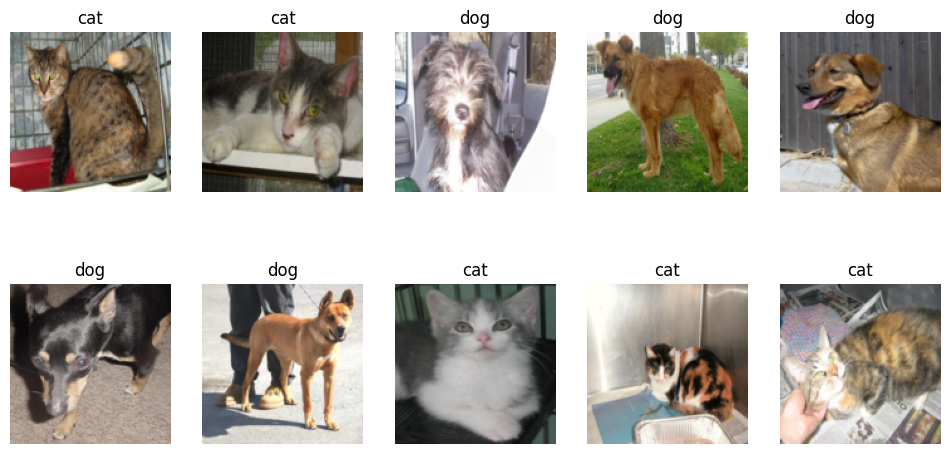

In [ ]:
draw(2, 5, data)

In [ ]:
train_data, val_data, test_data = torch.utils.data.random_split(
    dataset=data, 
    lengths=[int(DATA_SIZE * 0.4), int(DATA_SIZE * 0.4), int(DATA_SIZE * 0.2)], 
    generator=torch.Generator().manual_seed(42)
)

dataset = {
    'train': train_data, 
    'val': val_data,
    'test': test_data
}

In [ ]:
num_workers = multiprocessing.cpu_count()
batch_size = 64

dataloaders = {
    sample_type: DataLoader(dataset[sample_type], batch_size=batch_size, shuffle=True, num_workers=num_workers)
                 for sample_type in ['train', 'val', 'test']
}

## Собственная модель

In [ ]:
class CatDogClassifier(nn.Module):
    def __init__(self):
        super(CatDogClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs):
    def print_metrics(sample_type, sum_loss, corrects, len_dataset):
        final_loss = round(sum_loss / len_dataset, 4)
        final_acc = round(corrects / len_dataset * 100, 2)

        print(f"{sample_type}: loss ≈ {final_loss}, acc ≈ {final_acc}%")

    def train(dataloader):
        model.train()
        sum_loss, corrects = 0, 0

        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            sum_loss += loss.item() * images.size(0)
            corrects += (predicted == labels).sum().item()

        scheduler.step()
        print_metrics('train', sum_loss, corrects, len(dataloader.dataset))

    def validate(dataloader):
        model.eval()
        sum_loss, corrects = 0, 0

        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            sum_loss += loss.item() * images.size(0)
            corrects += (predicted == labels).sum().item()

        print_metrics('val', sum_loss, corrects, len(dataloader.dataset))

    start_time = time.time()
 
    for epoch in range(num_epochs):
        print(f"{epoch + 1} / {num_epochs} epochs")
        train(dataloaders['train'])
        validate(dataloaders['val'])
        print("-" * 10)
  
    end_time = time.time()
    print(f"{int(end_time - start_time)} seconds")
    return model

In [ ]:
model = CatDogClassifier().to(DEVICE)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-1)

In [ ]:
model = train_model(model, dataloaders, criterion, optimizer, scheduler, 10)

1 / 10 epochs
train: loss ≈ 0.6571, acc ≈ 60.72%
val: loss ≈ 0.62, acc ≈ 65.4%
----------
2 / 10 epochs
train: loss ≈ 0.6037, acc ≈ 67.55%
val: loss ≈ 0.5889, acc ≈ 69.11%
----------
3 / 10 epochs
train: loss ≈ 0.5689, acc ≈ 70.64%
val: loss ≈ 0.5724, acc ≈ 69.82%
----------
4 / 10 epochs
train: loss ≈ 0.5436, acc ≈ 72.52%
val: loss ≈ 0.5458, acc ≈ 72.33%
----------
5 / 10 epochs
train: loss ≈ 0.5134, acc ≈ 74.68%
val: loss ≈ 0.5263, acc ≈ 73.91%
----------
6 / 10 epochs
train: loss ≈ 0.4916, acc ≈ 76.25%
val: loss ≈ 0.5213, acc ≈ 74.31%
----------
7 / 10 epochs
train: loss ≈ 0.4851, acc ≈ 76.66%
val: loss ≈ 0.5203, acc ≈ 74.5%
----------
8 / 10 epochs
train: loss ≈ 0.4821, acc ≈ 77.01%
val: loss ≈ 0.5165, acc ≈ 74.79%
----------
9 / 10 epochs
train: loss ≈ 0.4796, acc ≈ 77.21%
val: loss ≈ 0.515, acc ≈ 74.78%
----------
10 / 10 epochs
train: loss ≈ 0.4756, acc ≈ 77.61%
val: loss ≈ 0.5132, acc ≈ 75.04%
----------
1137 seconds


## Transfer Learning

In [ ]:
smart_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(DEVICE)
smart_model.fc = nn.Linear(smart_model.fc.in_features, 2).to(DEVICE)

smart_optimizer = optim.Adam(smart_model.parameters(), lr=1e-4)
smart_scheduler = torch.optim.lr_scheduler.StepLR(smart_optimizer, step_size=5, gamma=1e-1)

In [ ]:
smart_model = train_model(smart_model, dataloaders, criterion, smart_optimizer, smart_scheduler, 10)

1 / 10 epochs
train: loss ≈ 0.1479, acc ≈ 93.8%
val: loss ≈ 0.0875, acc ≈ 96.65%
----------
2 / 10 epochs
train: loss ≈ 0.0233, acc ≈ 99.27%
val: loss ≈ 0.0971, acc ≈ 96.63%
----------
3 / 10 epochs
train: loss ≈ 0.0094, acc ≈ 99.71%
val: loss ≈ 0.1055, acc ≈ 96.55%
----------
4 / 10 epochs
train: loss ≈ 0.004, acc ≈ 99.9%
val: loss ≈ 0.1022, acc ≈ 96.75%
----------
5 / 10 epochs
train: loss ≈ 0.0037, acc ≈ 99.88%
val: loss ≈ 0.1788, acc ≈ 95.73%
----------
6 / 10 epochs
train: loss ≈ 0.0055, acc ≈ 99.84%
val: loss ≈ 0.1015, acc ≈ 97.12%
----------
7 / 10 epochs
train: loss ≈ 0.0014, acc ≈ 99.99%
val: loss ≈ 0.1046, acc ≈ 96.97%
----------
8 / 10 epochs
train: loss ≈ 0.0011, acc ≈ 99.98%
val: loss ≈ 0.0941, acc ≈ 97.28%
----------
9 / 10 epochs
train: loss ≈ 0.0007, acc ≈ 100.0%
val: loss ≈ 0.0938, acc ≈ 97.32%
----------
10 / 10 epochs
train: loss ≈ 0.0011, acc ≈ 99.99%
val: loss ≈ 0.0958, acc ≈ 97.31%
----------
1175 seconds


In [ ]:
def calculate_metrics(model, dataloader):
    sum_loss, corrects = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)

            sum_loss += loss.item() * images.size(0)
            corrects += (predicted == labels).sum().item()

    final_loss = round(sum_loss / len(dataloader.dataset), 4)
    final_acc = round(corrects / len(dataloader.dataset) * 100, 2)

    print(f"test: loss ≈ {final_loss}, acc ≈ {final_acc}%")

## Сравнение метрик


In [ ]:
calculate_metrics(model, dataloaders['test'])

test: loss ≈ 0.5216, acc ≈ 74.48%


In [ ]:
calculate_metrics(smart_model, dataloaders['test'])

test: loss ≈ 0.1171, acc ≈ 96.95%


## Вывод

В ходе выполнения лабораторной работы было обучено 2 модели. Модель ResNet18 справилось с поставленной задачей лучше, чем собственная